# ICE
For further explanation of the methods functioning, refer to the project report where everything is described in detail.

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pickle

import sys

import warnings
warnings.filterwarnings("ignore")

In [5]:
# import specific files
from ConceptExtractor import ConceptExtractor

## Loading Model and Preparing Data

In [6]:
def load_data(batch_size=256, valid_size=0.15, num_workers=0, shuffle_train=False):
    # transformation pipleine from pytorch vgg16 documentation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
    ])

    train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
    test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

    # create dataloaders for batching
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle_train, num_workers=num_workers)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader


In [7]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg16_bn", pretrained=True)
print(model)

Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar10_vgg16_bn-6ee7ea24.pt" to /root/.cache/torch/hub/checkpoints/cifar10_vgg16_bn-6ee7ea24.pt
100%|██████████| 58.3M/58.3M [00:01<00:00, 38.4MB/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Applying Invertible Concecpt-based Explanations
The technique is implemented manually and implementation details can be found in ncav_utils.py and ConceptExtractor.py \\
We will use batch zero for training the reducer (retrieving the concepts from the train set) and then evaluate the concepts on the whole test dataset. We choose an activation layer in the middle as the ones in the end provide too coarse concepts and the ones at the beginning only focus on simple features. The final layer decision is based on the optimal number of concepts that are found using the consine similarity that have a reasonable number of concepts s.t. they are human-understandable.

In [8]:
# take batch and extract activations from model for train batch
train_loader, test_loader = load_data(batch_size=512, valid_size=0.15, num_workers=0)
train_batch0 = next(iter(train_loader))
print(f"reducer training samples: {train_batch0[0].shape}, lables: {train_batch0[1].shape}")
print(f"label distribution: {torch.bincount(train_batch0[1], minlength=10)}")

# register forward hook for model to extract specific activation layers
target_layers = [36, 32, 29, 26, 22, 19] # 42 last layer, 39 - penultimate layer
activations = {}
train_hooks = []

# hook function to store activations
def hook_fn(name):
    def fn(module, input, output): # actual hook function
        """
        module: layer itself
        input: input to layer
        output: output of layer
        """
        activations[name] = output.detach()
    return fn # returns created hook function

for target_layer in target_layers:
    hook = model.features[target_layer].register_forward_hook(hook_fn(f"layer_{target_layer}"))
    train_hooks.append(hook)

# forward pass
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_batch0_samples, train_batch0_labels = train_batch0
train_batch0 = train_batch0_samples.to(device)

model.eval()
with torch.no_grad():
    train_batch0_logits = model(train_batch0_samples)

# checking activation shapes for layers
for name, activation in activations.items():
    print(f"{name} activation shape: {activation.shape}, nonzero: {torch.all(activation >= 0)}")


# remove hooks:
for hook in train_hooks:
    hook.remove()

100%|██████████| 170M/170M [00:04<00:00, 42.5MB/s]


reducer training samples: torch.Size([512, 3, 32, 32]), lables: torch.Size([512])
label distribution: tensor([52, 66, 45, 47, 51, 41, 53, 50, 49, 58])
layer_19 activation shape: torch.Size([512, 256, 8, 8]), nonzero: True
layer_22 activation shape: torch.Size([512, 256, 8, 8]), nonzero: True
layer_26 activation shape: torch.Size([512, 512, 4, 4]), nonzero: True
layer_29 activation shape: torch.Size([512, 512, 4, 4]), nonzero: True
layer_32 activation shape: torch.Size([512, 512, 4, 4]), nonzero: True
layer_36 activation shape: torch.Size([512, 512, 2, 2]), nonzero: True


In [9]:
# create and test function used later to showcase TCAV scores for extracted concepts

def forward_from_layer(model, activation_map, layer):
    """
    helper function for TCAV - continue the forward pass from specific layer with activation map as input
    model: pytorch vgg16 architecture
    activation_map: torch.Tensor
    layer: specific start layer from which the forward pass continues
    """
    model.eval()
    with torch.no_grad():
        remaining_features = model.features[layer:]
        # continue with feature extractor
        x = remaining_features(activation_map)
        # prepare for classifier according to models documentation:
        # https://github.com/chenyaofo/pytorch-cifar-models/blob/master/pytorch_cifar_models/vgg.py
        x = torch.flatten(x, 1)
        # apply the classifier
        x = model.classifier(x)
        return x

# test forward form layer function
output1 = train_batch0_logits.clone().detach() # reuse computations from train batch 0
output2 = forward_from_layer(model, activations["layer_19"].clone(), layer=20)
output3 = forward_from_layer(model, activations["layer_29"].clone(), layer=30)
assert torch.all(output1 == output2), "outputs 1 & 2 do not coincide"
assert torch.all(output1 == output3), "outputs 1 & 3 do not coincide"

With this, we have now a function that can continue the forward pass of the model from any specified feature extractor layer.

One drawback of the method, is the hyperparameter selection for NMF. The number of concepts must be determined beforehand. In the literature, using the cosine similarity to measure the similarity of concepts and enforcing them to be dissimilar to a certain degree. Thus, we try this with our dataset and see if we get a meaningful number of concepts for different thresholds [0.1, 0.2, 0.3, 0.4, 0.5].

In [ ]:
def calc_concept_number(thresholds: list, A, init_concepts): # --> put in utils file
    """
    thresholds: list of thresholds for maximal similarity
    A: activation map
    init_concepts: initial number of allowed concepts --> will be reduced
    """
    # ideal number of concepts for each threshold; [nr concepts, P]
    concept_dict = {threshold: [None, None] for threshold in thresholds}

    for threshold in thresholds:
        # create concept extractor instance with specific activation layer
        ConceptExtractor_activations = ConceptExtractor(A, seed=1234)
        concepts = init_concepts
        similar_concepts = True
        while similar_concepts and concepts > 0:
            # train NMF
            ConceptExtractor_activations.apply_NMF(nr_concepts=concepts)
            # extract the P matrix where the rows correspond to the CAVs
            P = ConceptExtractor_activations.P
            # calculate the cosine similarity between the CAVs
            cos_sim = cosine_similarity(P)
            # extract the upper triangle, excluding the diagonal to get the similarities beteen CAVs
            cos_sim = np.triu(cos_sim, k=1)
            # check if all the CAVs are below the threshold
            above_threshold = cos_sim > threshold
            if above_threshold.sum() == 0:
                similar_concepts = False
                concept_dict[threshold][0] = concepts
                concept_dict[threshold][1] = P
            else:
                concepts -= 1
    return concept_dict

In [11]:
# retrieve the optimal concept number according to the cosine similarity for determined thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
concept_dicts = []
for target_layer in target_layers:
    layer_idx = f"layer_{target_layer}"
    A = activations[layer_idx].clone().numpy() # get layer and convert tensor to numpy
    A = np.transpose(A, (0, 2, 3, 1)) # reshape A to batch_size, height, width, channels
    concept_dict = calc_concept_number(thresholds, A, 20)
    concept_dicts.append(concept_dict)
    print(f"\n----Layer {target_layer}---")
    for threshold, concept in concept_dict.items():
        print(f"threshold: {threshold} - nr of concepts: {concept[0]}")


----Layer 36---
threshold: 0.1 - nr of concepts: 1
threshold: 0.2 - nr of concepts: 1
threshold: 0.3 - nr of concepts: 1
threshold: 0.4 - nr of concepts: 17
threshold: 0.5 - nr of concepts: 20

----Layer 32---
threshold: 0.1 - nr of concepts: 1
threshold: 0.2 - nr of concepts: 1
threshold: 0.3 - nr of concepts: 3
threshold: 0.4 - nr of concepts: 20
threshold: 0.5 - nr of concepts: 20

----Layer 29---
threshold: 0.1 - nr of concepts: 1
threshold: 0.2 - nr of concepts: 1
threshold: 0.3 - nr of concepts: 10
threshold: 0.4 - nr of concepts: 18
threshold: 0.5 - nr of concepts: 20

----Layer 26---
threshold: 0.1 - nr of concepts: 1
threshold: 0.2 - nr of concepts: 1
threshold: 0.3 - nr of concepts: 5
threshold: 0.4 - nr of concepts: 20
threshold: 0.5 - nr of concepts: 20

----Layer 22---
threshold: 0.1 - nr of concepts: 1
threshold: 0.2 - nr of concepts: 1
threshold: 0.3 - nr of concepts: 20
threshold: 0.4 - nr of concepts: 20
threshold: 0.5 - nr of concepts: 20

----Layer 19---
threshold: 

**TODO** add explanation of what I did and why I chose to procede with Layer 29 (wrt to the considerations of XAI evaluation from the lecture).

In [10]:
# get our final concept extractor
A = activations["layer_29"].clone().numpy() # get layer and convert tensor to numpy
A = np.transpose(A, (0, 2, 3, 1)) # reshape A to batch_size, height, width, channels
ConceptExtractor_final = ConceptExtractor(A, seed=1234)
ConceptExtractor_final.apply_NMF(nr_concepts=10)

We have trained the reducer and can apply the learned concepts now to our test dataset... **TODO** continue with explanation

In [11]:
# get all activations from test loader

# register forward hook for model to extract specific activation layers
target_layers = [29] # 42 last layer, 39 - penultimate layer
test_activations = {f"layer_{layer}": [] for layer in target_layers}
test_hooks = []

# hook function to store activations
def hook_fn(name):
    def fn(module, input, output): # actual hook function
        """
        module: layer itself
        input: input to layer
        output: output of layer
        """
        test_activations[name].append(output.detach())
    return fn # returns created hook function

for target_layer in target_layers:
    hook = model.features[target_layer].register_forward_hook(hook_fn(f"layer_{target_layer}"))
    test_hooks.append(hook)

model = model.to(device)
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        model(data)

for hook in test_hooks:
    hook.remove()

**TODO** TCAV score description --> formla implemented mentioned in the paper

In [12]:
def TCAV_directional_derivative(activation_layer: np.array, layer_name: int, cav_vector: np.array, epsilon: float, model, class_k: int) -> np.array:
    """
    function calculates the directional derivatives which measure the sensitivity of predictions of the model of class k
    w.r.t. the cav_vector
    Note: we assume for function inputs that activation_layer and cav_vector are calculated for class k and not mixed and
    that all parameters that are influenced by layer_name use the same layer
    Note: this function is only suitable for one image-batch
    :param activation_layer: layer retrieved from the model, has activations for class k,
    shape 4dim: (batch_size, height, width, channels)
    :param layer_name: name of activation_layer
    :param cav_vector: holds the a concept, shape: 1dim (channels)
    :param epsilon: parameter for the directional derivative, should be small
    :param model: model used to calculate the predictions, should be an intance with pretrained weights!
    :param class_k: index of the cth class [0:1000] as model outputs one of the 1000 ImageNet classes
    :return: directional_derivatives_C_l: the directional derviative for cav C from layer l as np.array of size: batch_size
    """
    model.eval()
    with torch.no_grad():
        input1 = activation_layer.clone() + epsilon*torch.tensor(cav_vector).view(1, cav_vector.shape[0], 1, 1)
        logit1 = forward_from_layer(model, input1, layer_name).detach().numpy()[:,class_k]
        logit2 = forward_from_layer(model, activation_layer.clone(), layer_name).detach().numpy()[:,class_k]
    return (logit1 - logit2) / epsilon

def TCAV_score(directional_derivatives_C_l: np.array) -> float:
    """
    function that calculates the fraction of images from class k where the concept C positively influenced the image
    being classified as k
    Note: we assume for all inputs that only class k was used to get actionvations, cavs,... otherwise the ouput
    is not meaningful
    Note: this function is only suitable for one image-batch
    :param directional_derivatives_C_l: I refer to information in TCAV_directional_derivative function
    :return: score, float between 0 and 1
    """
    return np.sum(directional_derivatives_C_l > 0) / directional_derivatives_C_l.shape[0]

def TCAV(activation_layer: np.array, layer_name: int, P: np.array, epsilon: float, model, class_k) -> np.array:
    """
    function that combines TCAV_directional_derivative and TCAV_score and returns TCAV scores for all cavs
    for parameter documentation, I refer to the function documentations
    Note: this function is only suitable for one image-batch
    :param P: is a matrix of shape (c', c) = (concept, channels) retrieved from NMF and holding the cav vectors
    :param class_k: index of the cth class [0:10] as model outputs one of the 10 classes
    :return: TCAV scores for all conecpts Ci for images of class k from layer l
    """
    scores = np.zeros(P.shape[0])
    for concept_idx in range(P.shape[0]):
        cav_vector = P[concept_idx].reshape(-1)
        derivatives = TCAV_directional_derivative(activation_layer, layer_name, cav_vector, epsilon, model, class_k)
        scores[concept_idx] = TCAV_score(derivatives)
    return scores

In [23]:
# function to plot the TCAV scores
def plot_TCAV(activation_layer, Concept_Extractor, classes, model, layer_name, epsilon=1e-6, save_path=None):
    fig, axes = plt.subplots(nrows=len(classes), ncols=1, figsize=(10, 20))
    # iterate through each class to calculate the concept presence for this specific class
    for i, ax in enumerate(axes):
        cav_scores = TCAV(activation_layer,
                      layer_name = layer_name,
                      P = Concept_Extractor.P,
                      epsilon = epsilon,
                      model = model,
                      class_k = i)

        x_values = range(len(cav_scores))
        x_labels = [i+1 for i in range(len(cav_scores))]
        ax.bar(x_values, cav_scores, color='C0')
        ax.set_xticks(x_values, x_labels)
        ax.set_xlabel('Concepts')
        ax.set_ylabel('TCAV Score')
        ax.set_ylim(0, 1)
        ax.set_title(f'Class {classes[i]}', fontsize=13)

    # ajust layout
    plt.tight_layout()
    plt.suptitle(f'TCAV Scores for {len(classes)} Concepts for Each Class', fontsize=20)
    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout(rect=[0, 0, 1, 0.98])

    if save_path:
        plt.savefig(save_path)

    plt.show()

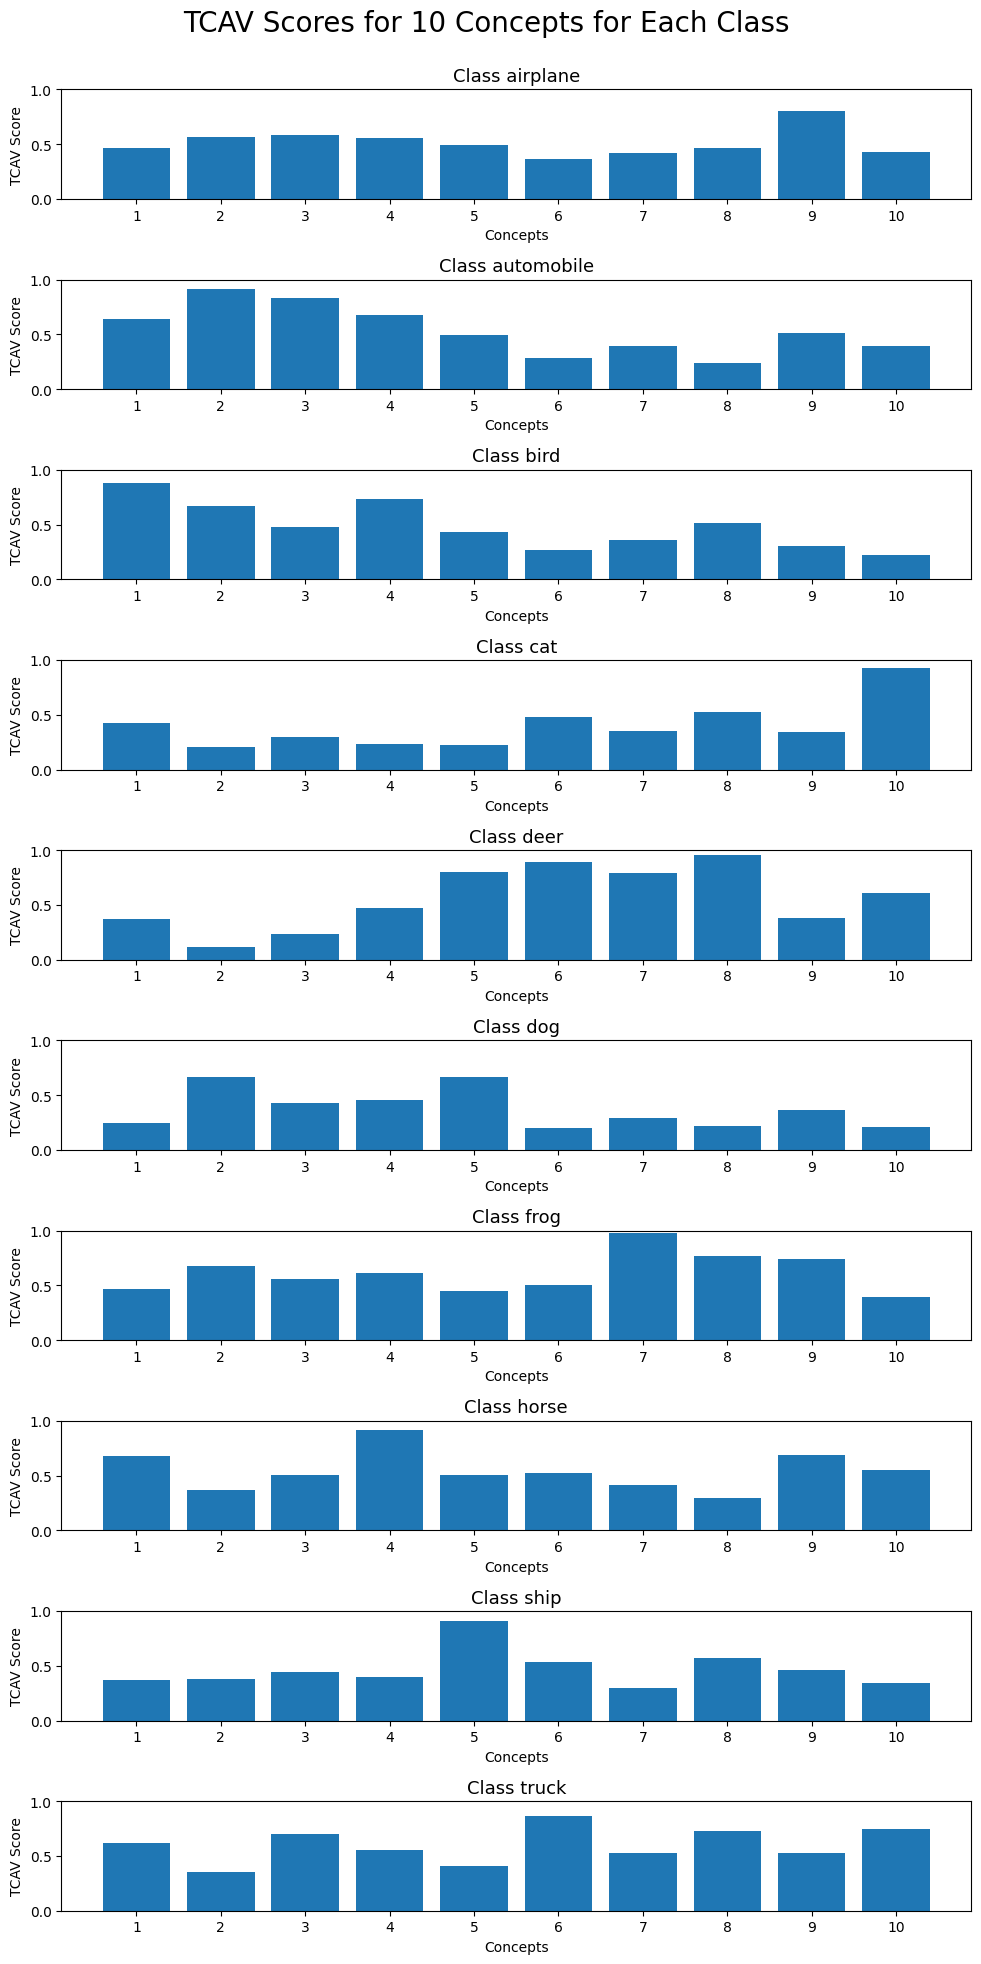

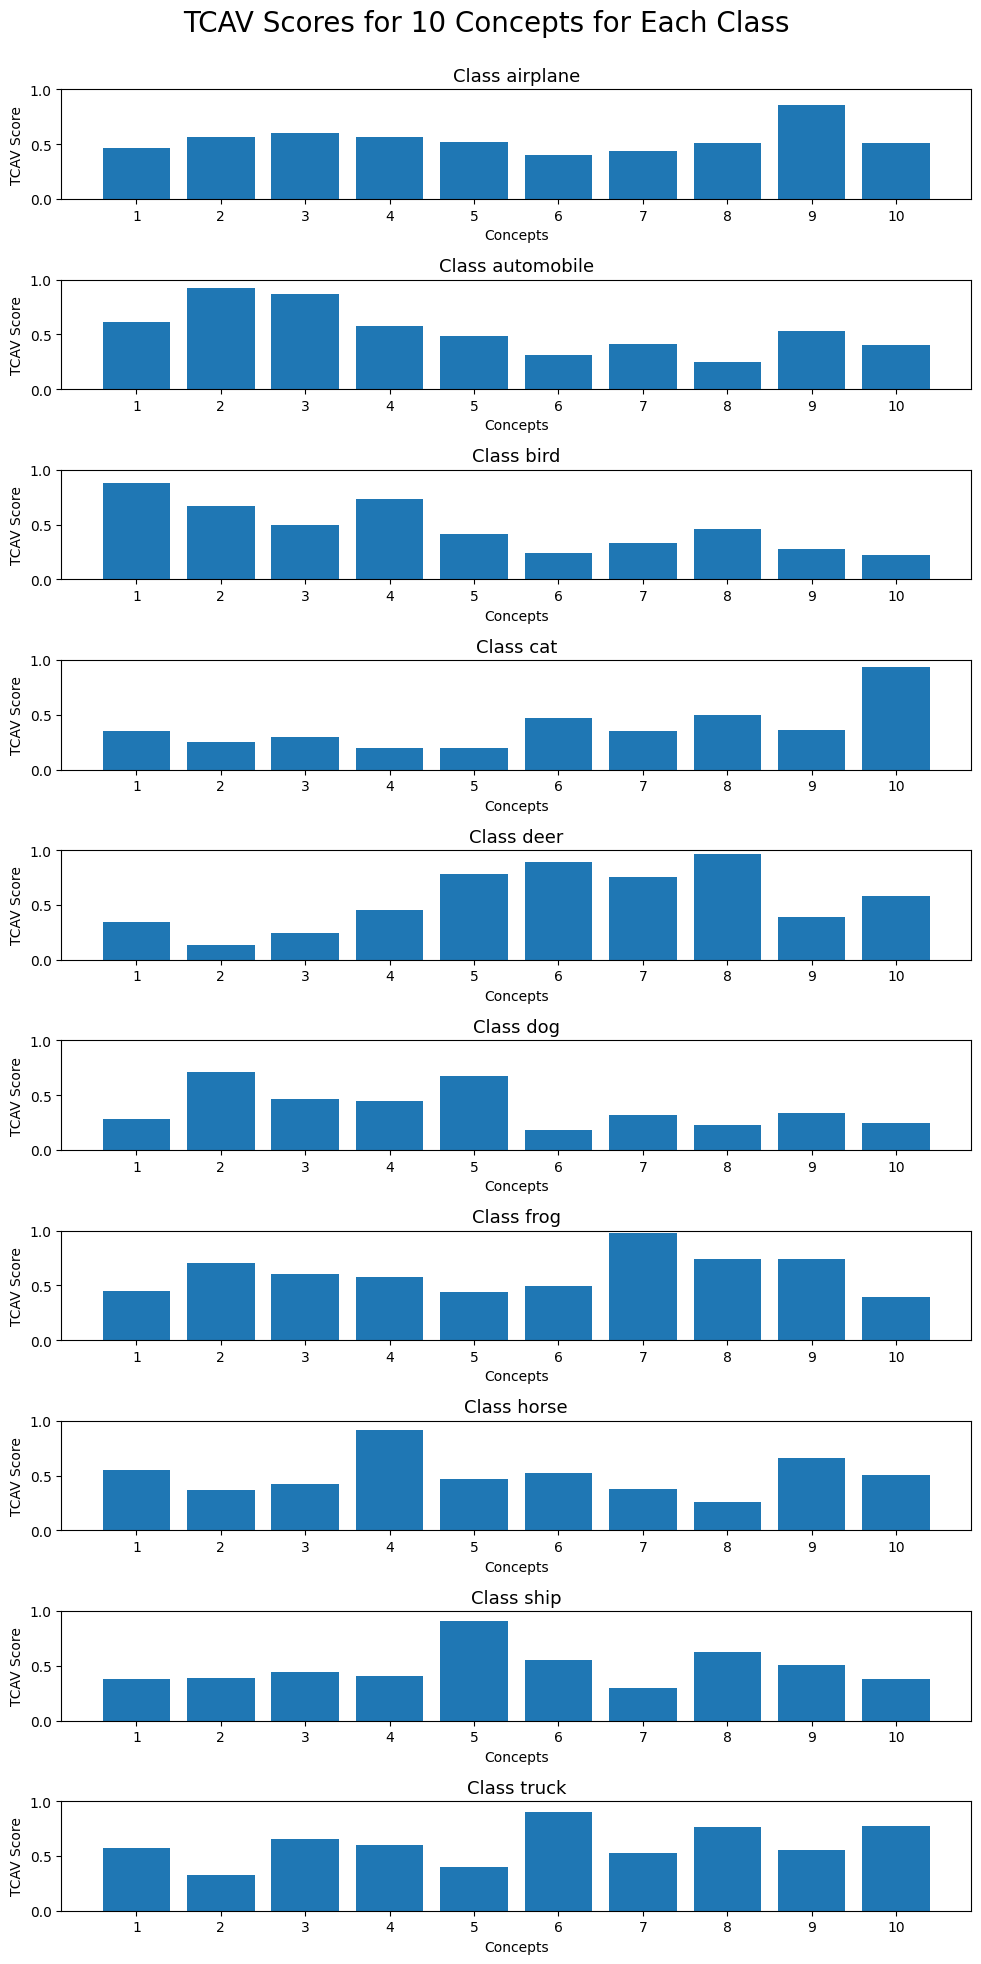

In [24]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
TCAV_save_path_train = 'TCAV_train.pdf'
TCAV_save_path_test = 'TCAV_test.pdf'
plot_TCAV(activations["layer_29"].clone(), ConceptExtractor_final, classes, model, layer_name=30, save_path=TCAV_save_path_train)
plot_TCAV(test_activations["layer_29"][0].clone(), ConceptExtractor_final, classes, model, layer_name=30, save_path=TCAV_save_path_test)

Next, we look for the presence of the extracted concepts in our test set.
Therefore, we will calculate the average concept presence and extract the top samples for each concept that has the highest and lowest presence.

In [13]:
def calc_avg_concept_presence(top_n, S_list, dataloader, ConceptExtractor): # --> move to utils
    # Initialize lists to accumulate data across batches
    all_avg_concept_presence = []

    # Iterate over all batches to collect data
    for batch_idx, (data, target) in enumerate(dataloader):
        S = S_list[batch_idx].copy()
        S = S.reshape((
            data.shape[0],
            ConceptExtractor.height,
            ConceptExtractor.width,
            ConceptExtractor.nr_concepts
        ))

        # Calculate the average concept presence for the current batch
        avg_concept_presence = np.mean(S, axis=(1, 2))  # Shape (batch_size x nr_concepts)

        # Accumulate filenames and corresponding avg concept presence
        all_avg_concept_presence.append(avg_concept_presence)

    # Convert the accumulated concept presence data to a single numpy array
    # print(len(all_avg_concept_presence))
    # print(all_avg_concept_presence[0].shape)
    all_avg_concept_presence = np.vstack(all_avg_concept_presence)  # Shape (total_samples x nr_concepts)
    # print("")
    # print(all_avg_concept_presence.shape)

    # Dictionary to store the top n filenames and concept presence for each concept
    top_n_imgs = {}

    # Calculate the top n indices globally for each concept
    for k in range(all_avg_concept_presence.shape[1]):  # Iterate over each concept (channel)
        sorted_indices_high = np.argsort(all_avg_concept_presence[:, k])[::-1]
        sorted_indices_low = np.argsort(all_avg_concept_presence[:, k])

        # Get the top n indices with the highest and lowest values
        top_n_indices_high = sorted_indices_high[:top_n]
        top_n_indices_low = sorted_indices_low[:top_n]

        # Store the top n filenames and their corresponding avg concept presence for both high and low
        top_n_imgs[f"concept_{k}"] = {
            'top_n_high': {
                'avg_concept_presence': [all_avg_concept_presence[idx, k] for idx in top_n_indices_high],
                'indices': top_n_indices_high
            },
            'top_n_low': {
                'avg_concept_presence': [all_avg_concept_presence[idx, k] for idx in top_n_indices_low],
                'indices': top_n_indices_low
            }
        }

    return top_n_imgs

In [14]:
Explainer_S = [] # holds the information for each activation map regarding the presence of a concept

for target_layer, test_activations_layer in test_activations.items():
    # get model activations for batch
    for idx in range(len(test_activations_layer)):
        A_test = test_activations_layer[idx].numpy()
        A_test = np.transpose(A_test, (0, 2, 3, 1))

        # apply the explainer (the already fitted NMF model)
        S = ConceptExtractor_final.explainer(A_test, batch_size=A_test.shape[0])
        Explainer_S.append(S)

avg_concept_presence = calc_avg_concept_presence(5, Explainer_S, test_loader, ConceptExtractor_final)

In [15]:
Explainer_S_all = []
heatmaps = []

for batch_idx, (data, target) in enumerate(test_loader):
    S = Explainer_S[batch_idx].copy()
    S = S.reshape((
        data.shape[0],
        ConceptExtractor_final.height,
        ConceptExtractor_final.width,
        ConceptExtractor_final.nr_concepts
    ))

    S_reshaped = S.copy()
    S_reshaped = np.transpose(S_reshaped, (0, 3, 1, 2)) #needed for interpolating S: batch_size x channels x height x width
    # heatmap size fits our log mel spectrograms, if others are used, then change size
    heatmap_batch = torch.nn.functional.interpolate(torch.from_numpy(S_reshaped), size=(32, 32), mode='bilinear', align_corners=False)

    # normalize the heatmaps
    normalized_heatmaps = np.zeros_like(heatmap_batch, dtype=np.float32)

    for b in range(data.shape[0]):
        for c in range(ConceptExtractor_final.nr_concepts):
            img_concept = heatmap_batch[b, c, :, :]
            min_val = torch.min(img_concept)
            max_val = torch.max(img_concept)

            normalized_img_concept = (img_concept - min_val) / (max_val - min_val)

            # thresholding the heatmaps s.t. concepts are larger than threshold
            #normalized_img_concept[normalized_img_concept < threshold] = 0
            normalized_heatmaps[b, c, :, :] = normalized_img_concept

    flattened_batch = [S[i] for i in range(S.shape[0])]
    Explainer_S_all.extend(flattened_batch)
    flattened_batch = [normalized_heatmaps[i] for i in range(normalized_heatmaps.shape[0])]
    heatmaps.extend(flattened_batch)

In [148]:
def plot_concept_images(concept_dict, dataloader, S=None, threshold=0.5, background_alpha=0.6, plot_lowest=True, save_path=None):
    """
    Plots images for each concept showing the top 5 highest and lowest concept presence.

    Args:
    - concept_dict: Dictionary containing concept presence and indices.
    - dataloader: PyTorch dataloader containing the images.
    - S: concept strengths for all images
    - threshold: threshold for concept strengths
    - background_alpha: alpha of image regions without concept presence
    """
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # values for unnormalizing image
    mean=torch.tensor([0.4914, 0.4822, 0.4465])
    std=torch.tensor([0.2023, 0.1994, 0.201])

    num_concepts = len(concept_dict)
    rows_per_concept = 2 if plot_lowest else 1
    total_rows = num_concepts * rows_per_concept
    cols = 5

    fig, axes = plt.subplots(total_rows, cols, figsize=(12, 30))

    if total_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for concept_idx, (concept, data) in enumerate(concept_dict.items()):
        # extract high and low indices
        high_indices = data['top_n_high']['indices']
        low_indices = data['top_n_low']['indices']

        # fetch corresponding images from dataloader
        high_images = [dataloader.dataset[idx][0] for idx in high_indices]
        high_labels = [dataloader.dataset[idx][1] for idx in high_indices]
        low_images = [dataloader.dataset[idx][0] for idx in low_indices]
        low_labels = [dataloader.dataset[idx][1] for idx in low_indices]

        if S is not None:
            high_concepts = [S[idx][concept_idx] for idx in high_indices]
            low_concepts = [S[idx][concept_idx] for idx in low_indices]

        row_offset = concept_idx * rows_per_concept

        # plot top 5 high concept presence images
        axes[row_offset, 2].annotate(f"\nConcept {concept_idx + 1}",
                          xy=(0.5, 1.15), xycoords='axes fraction',
                          ha='center', va='bottom', fontsize=14)

        for i, (img, label) in enumerate(zip(high_images, high_labels)):
            ax = axes[row_offset, i]
            # prepare image
            img = img * std[:, None, None] + mean[:, None, None]
            img = img.permute(1, 2, 0)
            # ensure image is between 0 and 1
            img = torch.clamp(img, 0, 1)

            if S is not None:
                concept = high_concepts[i].copy()
                # ensure concept is between 0 and 1
                concept = np.clip(concept, 0, 1)
                # create concept mask where concept is present in image
                mask = concept > threshold
                highlighted_regions = np.zeros_like(concept)
                highlighted_regions[mask] = concept[mask]
                cmap = plt.cm.viridis
                heatmap = cmap(highlighted_regions)
                # make the heatmap of the concept to RGB
                heatmap_rgb = heatmap[..., :3]
                blended_image = img.numpy().copy()
                # change image alpha
                blended_image *= background_alpha
                # replace image pasts of mask with concept
                blended_image[mask] = heatmap_rgb[mask]
                ax.imshow(blended_image)
            else:
                ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"High {i + 1} - {classes[label]}")

        if plot_lowest:
            # plot top 5 low concept presence images
            for i, (img, label) in enumerate(zip(low_images, low_labels)):
                ax = axes[row_offset+1, i]
                img = img * std[:, None, None] + mean[:, None, None]
                img = img.permute(1, 2, 0)
                img = torch.clamp(img, 0, 1)
                ax.imshow(img)  # convert from CHW to HWC
                if S is not None:
                    concept = low_concepts[i].copy()
                    concept = np.clip(concept, 0, 1)
                    mask = concept > threshold
                    highlighted_regions = np.zeros_like(concept)
                    highlighted_regions[mask] = concept[mask]
                    cmap = plt.cm.viridis
                    heatmap = cmap(highlighted_regions)
                    blended_image = img.numpy().copy()
                    blended_image *= background_alpha
                    blended_image[mask] = heatmap_rgb[mask]
                    ax.imshow(blended_image)
                else:
                    ax.imshow(img)
                ax.axis('off')
                ax.set_title(f"Low {i + 1} - {classes[label]}")

    fig.suptitle("Prototypical Images for Concepts\n", fontsize=20, y=0.99)
    fig.subplots_adjust(top=0.95, wspace=0.1)
    fig.tight_layout()

    if save_path:
        plt.savefig(save_path)

    plt.show()

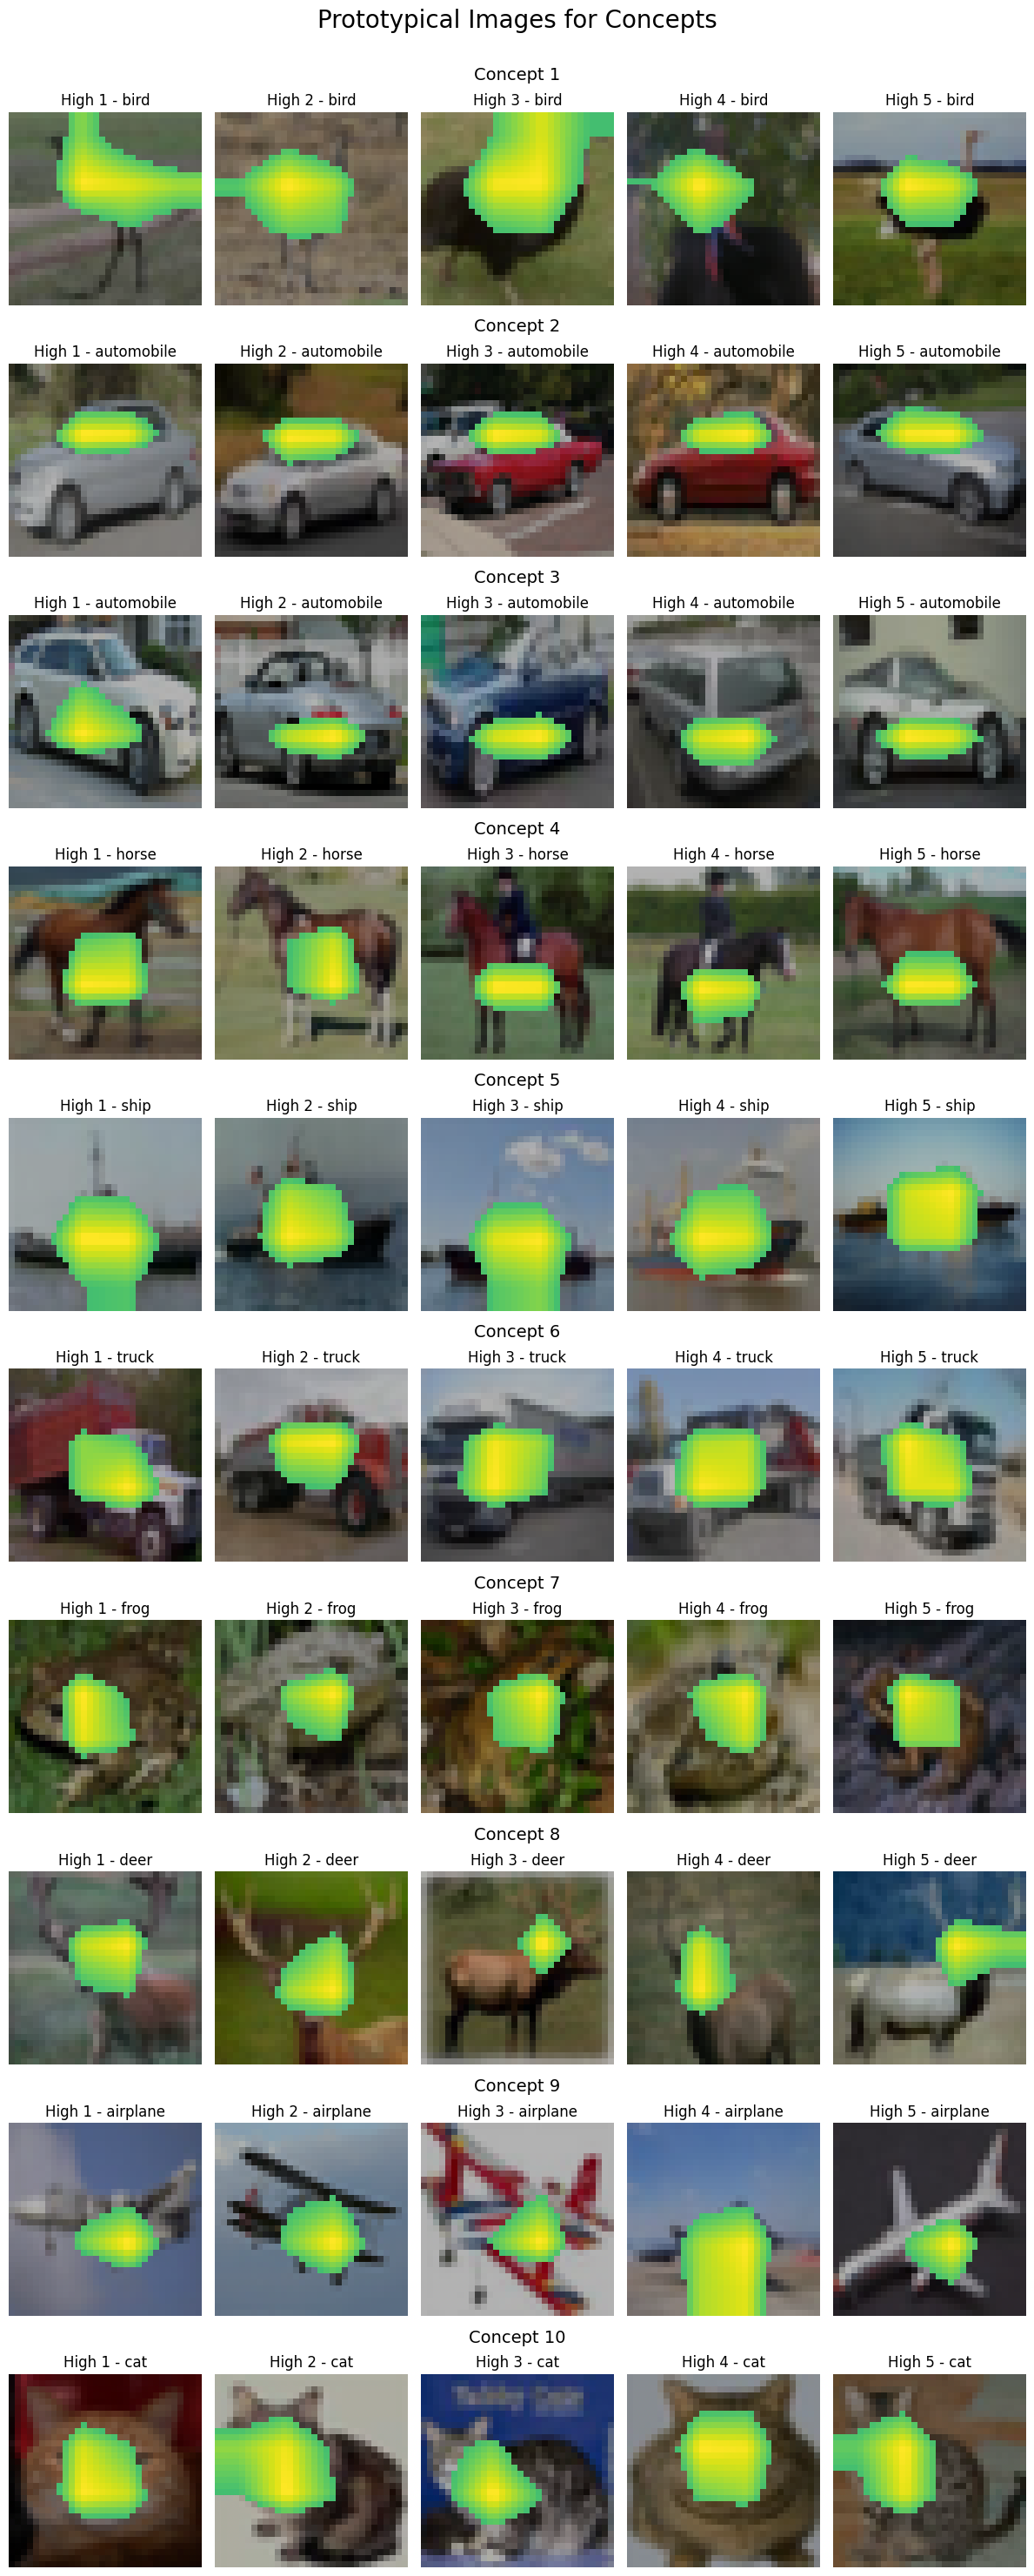

In [149]:
concept_plots_save_path = 'concept_plots.pdf'
plot_concept_images(avg_concept_presence, test_loader, S=heatmaps, threshold=0.7, background_alpha=0.7, plot_lowest=False, save_path=concept_plots_save_path)